# Apache Solr and the LIRE plugin for CBIR

This is a work-in-progress notebook to show some examples of using Apache Solr with the LIRE plugin. You only need to have the following installed in order to run it:

- Python >= 3.6;
- requests;
- matplotlib.

There is a `pysolr` package available, but we will only use API calls with `requests`.

In [1]:
import json
import os

import matplotlib.pyplot as plt
import requests

%matplotlib inline

In [2]:
fields = [
    "ph",  # PHOG (pyramid histogram of oriented gradients)
    "cl",  # ColorLayout (from MPEG-7)
    "eh",  # EdgeHistogram (from MPEG-7)
    "jc",  # JCD (joined descriptor of CEDD and FCTH)
    "oh",  # OpponentHistogram (simple color histogram in the opponent color space)
    "sc",  # ScalableColor (from MPEG-7)
    "ce",  # CEDD (very compact and accurate joint descriptor)
    "fc",  # FCTH (more accurate, less compact than CEDD)
    "ac",  # AutoColorCorrelogram (color to color correlation histogram)
    "ad",  # ACCID
    "fo",  # FuzzyOpponentHistogram (fuzzy color histogram)
    "jh",  # JointHistogram
]

In [3]:
source_img = 'COCO_val2014_000000481654.jpg'

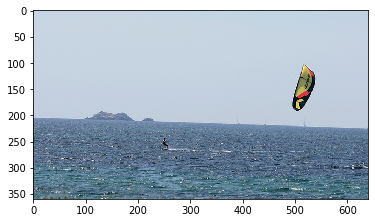

In [4]:
img = requests.get(f'http://localhost:8000/{source_img}', stream=True)

plt.imshow(plt.imread(img.raw, format='jpg'))

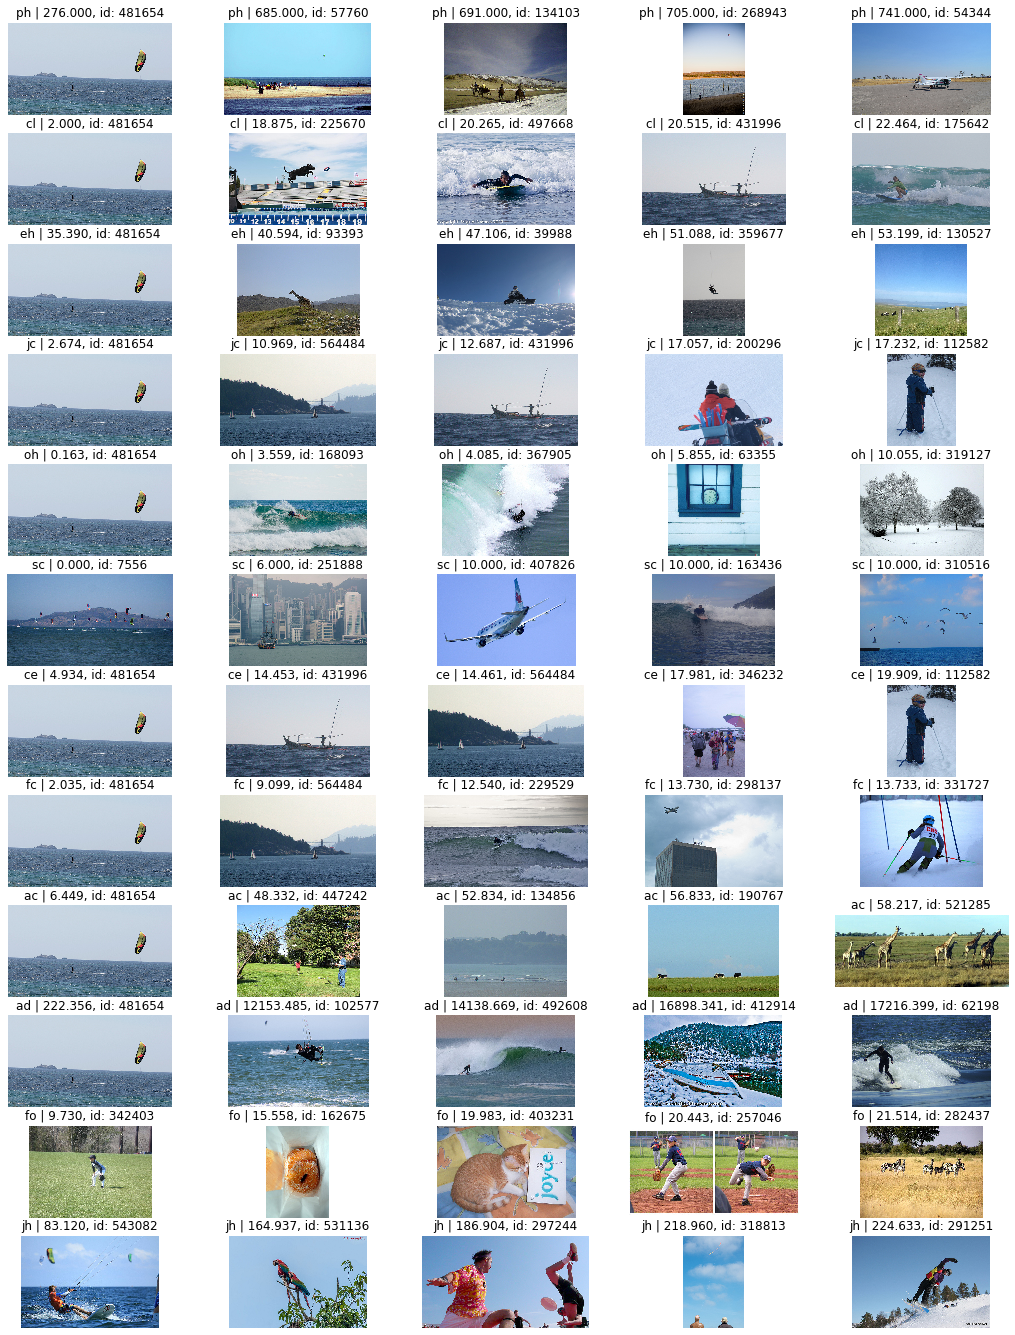

In [11]:
idx = 'lire_mscoco_val2014'

fig = plt.figure(figsize=(18, 24))
to_show = 5

for f, field in enumerate(fields):
    res = requests.get(f'http://localhost:8983/solr/{idx}/lireq', 
                       params={
                           'fl': '*,score', 
                           'accuracy': 0.99,
                           'rows': 20, 
                           # 'id': f'/data/mscoco/val2014/{source_img}',
                           'url': f'http://localhost:8000/{source_img}',
                           'field': field,
                           'ms': 'false'
                       })

    j_res = res.json()
    docs = j_res['response']['docs']

    del j_res['response']['docs']

    for i, d in enumerate(docs[0:to_show]):
        filename = os.path.basename(d['id'])
        img = requests.get(f'http://localhost:8000/{filename}', stream=True)
        img_id = int(filename.split('_')[-1].replace('.jpg', '').lstrip('0'))

        ax = fig.add_subplot(len(fields), to_show, f * to_show + i + 1)
        ax.title.set_text(f"{field} | {d['score']:.3f}, id: {img_id}")
        ax.axis('off')
        ax.imshow(plt.imread(img.raw, format='jpg'))

In [10]:
hist = '4ICAgICAgICAwZCAgICAgICAgICAoaCAkYCAgICAgICA0sCAgYCAgICAgICAoKCAgICAgICAgICAkJCAgICAgICAgICAkJA='

bs_query = '121 c0a e5d c26 efb ab7 33b eee 918 d38 80a fd9 b60 b95 394 6eb 6ef aff 410 333 571 8f7 d86 b1d a8b 10 aaa 450 e2c 2b0 eac 72c 26e 26e 181 93c 9f5 344 601 a01 592 72e 22f f14 1d4 451 f89 d65 f0d 949 318 49 c51 b34 161 44f 538 555 a2d 6e4 41b 209 958 670 7f5 12 46b 30c 651 595 258 258 959 84b b59 19b 155 10c ba6 38d 7a7 1ce 1bc 9f8 721 5ca 591 449 1de 687 9ff 2c5 de3 bd2 9da 7c7 501 b90 80 8ad'
ms_query = 'R003429 R003219 R003082 R003030 R002140 R001360 R000784 R000671 R000538 R000115 R000030 R000028 R000001 R000005 R000020 R000000 R000013 R000014 R000004 R000015 R000025 R000003 R000018 R000024 R000010'

# bs_query = '121 c0a e5d c26 efb ab7 33b eee 918 d38 80a fd9 b60 b95 394 6eb 6ef aff 410 333 571 8f7 d86 b1d a8b 10 aaa 450 e2c 2b0 eac 72c 26e 26e 181 93c 9f5 344 601 a01 592 72e 22f f14 1d4 451 f89 d65 f0d 949 318 49 c51 b34 161 44f 538 555 a2d 6e4 41b 209 958 670 7f5 12 46b 30c 651 595 258 258 959 84b b59 19b 155 10c ba6 38d 7a7 1ce 1bc 9f8 721 5ca 591 449 1de 687 9ff 2c5 de3 bd2 9da 7c7 501 b90 80'
# ms_query = 'R003429^1.00 R003219^0.96 R003082^0.92 R003030^0.88 R002140^0.83 R001360^0.79 R000784^0.75 R000671^0.71 R000538^0.67 R000115^0.63 R000030^0.58 R000028^0.54 R000001^0.50 R000005^0.46 R000020^0.42 R000000^0.38 R000013^0.33 R000014^0.29 R000004^0.25 R000015^0.21 R000025^0.17 R000003^0.13 R000018^0.08 R000024^0.04'

# Search with lireq and URL
res = requests.get(f'http://localhost:8983/solr/{idx}/lireq', 
                   params={
                       'fl': 'id,d', 
                       'accuracy': 0.89,
                       'url': f'http://localhost:8000/{source_img}',
                       'rows': 30, 
                       'field': 'ce_ha'
                   })

# print(json.dumps(res.json(), indent=2))
r1 = res.json()['response']['docs']

# Search with lireq and feature + hashes
res = requests.get(f'http://localhost:8983/solr/{idx}/lireq',
                   params={
                       'fl': 'id,d', 
                       'accuracy': 0.89,
                       'rows': 30, 
                       'feature': hist,
                       'hashes': f'{bs_query}',
                       'field': 'ce'
                   })

# print(json.dumps(res.json(), indent=2))
r2 = res.json()['response']['docs']

# Search with select and lirefunc
res = requests.get(f'http://localhost:8983/solr/{idx}/select', 
                   params={
                       'fl': f'id,d:lirefunc(ce, {hist})', 
                       'accuracy': 0.89,
                       'q': f'ce_ha:({bs_query})',
                       'rows': 30, 
                       'sort': f'lirefunc(ce, {hist}) asc',
                       'field': 'ce_ha'
                   })

# print(json.dumps(res.json(), indent=2))
r3 = res.json()['response']['docs']

# Search with lireq and feature + metric spaces
res = requests.get(f'http://localhost:8983/solr/{idx}/lireq',
                   params={
                       'fl': 'id,d', 
                       'accuracy': 0.89,
                       'rows': 30, 
                       'feature': hist,
                       'hashes': f'{ms_query}',
                       'field': 'ce',
                       'ms': 'true'
                   })

# print(json.dumps(res.json(), indent=2))
r4 = res.json()['response']['docs']

print(r1 == r2)
print(r1 == r3)
print(r1 == r4)

True
True
True
